In [1]:
import pprint

# Data libs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

# Classifiers 
from sklearn.ensemble import GradientBoostingClassifier

# Analysis libs
from itertools import cycle
from sklearn.metrics import  auc, roc_curve
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

In [2]:
malware_data_filepath = '../datasets/Obfuscated/Obfuscated-MalMem2022_edited.csv'
malware_data = pd.read_csv(malware_data_filepath)

In [3]:
X_drop_columns = ['Class', 
                'Category', 
                'svcscan.interactive_process_services', 
                'handles.nport', 
                'modules.nmodules',
                'pslist.nprocs64bit', 
                'callbacks.ngeneric']
X = malware_data.drop(columns=X_drop_columns)

y_column = malware_data.Category
class_le = LabelEncoder()
y = class_le.fit_transform(y_column)

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X ,y, test_size=0.3, random_state=0, stratify=y)

In [5]:
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (41017, 50)
y_train shape: (41017,)
X_test shape: (17579, 50)
y_test shape: (17579,)


In [6]:
gb = GradientBoostingClassifier(learning_rate=1.0, random_state=1)
clf = gb.fit(X_train, y_train)
print('Training accuracy:', clf.score(X_train, y_train))
print('Test accuracy:', clf.score(X_test, y_test))

Training accuracy: 0.9023087987907453
Test accuracy: 0.856704021844246


In [7]:
y_pred = clf.predict(X_test)
print(f"Accuracy score: {accuracy_score(y_test, y_pred)}")
print(f"Precision score: {precision_score(y_test, y_pred, average='weighted', zero_division=0)}")
print(f"Recall score: {recall_score(y_test, y_pred, average='weighted', zero_division=0)}")
print(f"F-1 score: {f1_score(y_test, y_pred, average='weighted', zero_division=0)}")

Accuracy score: 0.856704021844246
Precision score: 0.8566063757892107
Recall score: 0.856704021844246
F-1 score: 0.856512839331346


In [8]:
cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
cm

array([[8789,    0,    1,    0],
       [   0, 1954,  454,  529],
       [   0,  302, 2309,  395],
       [   1,  516,  321, 2008]])

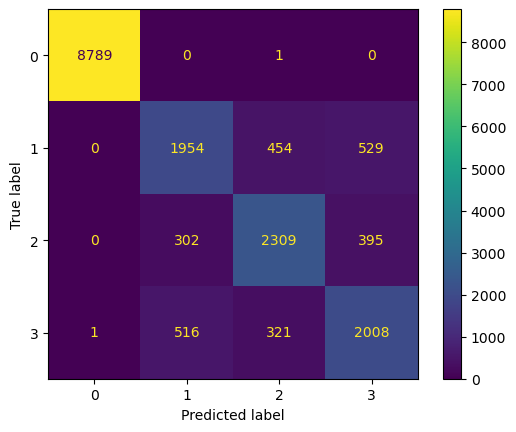

In [8]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()

In [9]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      8790
           1       0.70      0.67      0.68      2937
           2       0.75      0.77      0.76      3006
           3       0.68      0.71      0.70      2846

    accuracy                           0.86     17579
   macro avg       0.78      0.78      0.78     17579
weighted avg       0.86      0.86      0.86     17579



In [10]:
scores = cross_val_score(clf, X, y, cv=10)

In [11]:
print(f"Scores from CV: {scores}")
print(f"Mean of CV scores: {scores.mean()}")
print(f"Standard Deviation of CV scores: {scores.std()}")

Scores from CV: [0.75887372 0.77679181 0.8059727  0.85102389 0.87320819 0.83788396
 0.83597884 0.83819764 0.79245605 0.76446493]
Mean of CV scores: 0.8134851723115514
Standard Deviation of CV scores: 0.03730740651754181


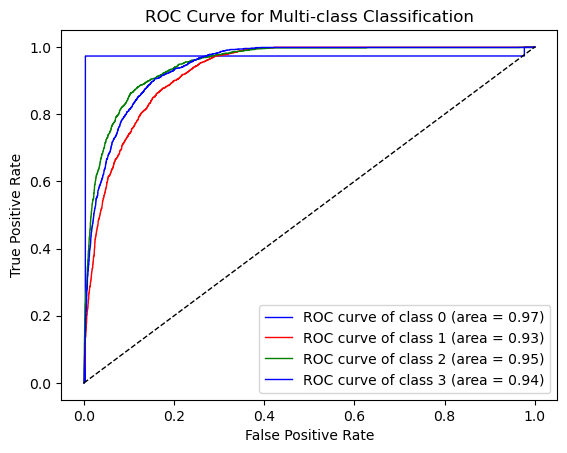

In [12]:
y_bin = label_binarize(y, classes=np.unique(y))
n_classes = y_bin.shape[1]


X_train, X_test, y_train, y_test = train_test_split(X, y_bin, test_size=0.2, random_state=42)

classifier = OneVsRestClassifier(GradientBoostingClassifier(learning_rate=1.0, random_state=1))
y_score = classifier.fit(X_train, y_train).predict_proba(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve
plt.figure()
colors = cycle(['blue', 'red', 'green'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=1, label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multi-class Classification')
plt.legend(loc="lower right")
plt.show()

### Report and results
In using the model GradientBoost, we can see that the model did somewhat well in this task. The model was able to classify benign samples quite well but for other classes they seem to be more missed classified in comparision to benign. We can see that the scores are decent meritting at least 0.85 for each metric. We can see that in the ROC Graphic, the model does not seem to define benign samples as well as the other models.  